Wrapping Functions
==================

In this tutorial, we will see how to wrap functions in order to make them compatible with Fiatlight.

Most of the time, functions are wrapped automatically. In the example below, the function `times_two` is wrapped
automatically by Fiatlight into a `FunctionWithGui` object:

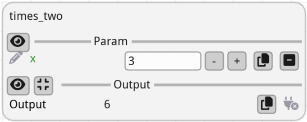

In [4]:
import fiatlight as fl
def times_two(x: int) -> int:
    return x * 2
fl.run(times_two, app_name="Times two")  # the function will be wrapped automatically into a FunctionWithGui object

> In order to be wrapped automatically, a function must have a typed signature (see [Typed signatures](#typed-signatures)).

`FunctionWithGui` is one of the core classes of FiatLight: it wraps a function with a GUI that presents its inputs and outputs.

* **Documentation**: See its [API](api_function_with_gui) for detailed information.
* **Source code**: View its full code [online](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiat_core/function_with_gui.py).


Typed Signatures
================

Importance of Typed Signatures
------------------------------

To automatically create a GUI for function parameters, Fiatlight **requires** type information for both the parameters and the return value of the functions. This is achieved using type hints in the function signature.

For example, an untyped function signature looks like this:

In [4]:
def foo(a, b):
    return a + b

In contrast, a typed version is:

In [5]:
def foo(a: int, b: float) -> float:
    return a + b

> More information about type hints can be found in [PEP 484](https://www.python.org/dev/peps/pep-0484/).
> _Type hints specify the type of a variable in Python. They are not mandatory but are a good practice, as they help catch bugs early in the development process._


Typed vs Untyped Functions GUI
------------------------------

In the example below, `math.sin` and `math.cos` are unfortunately not typed. `my_cos` is a wrapper around `math.cos` that includes type information.

**Code**

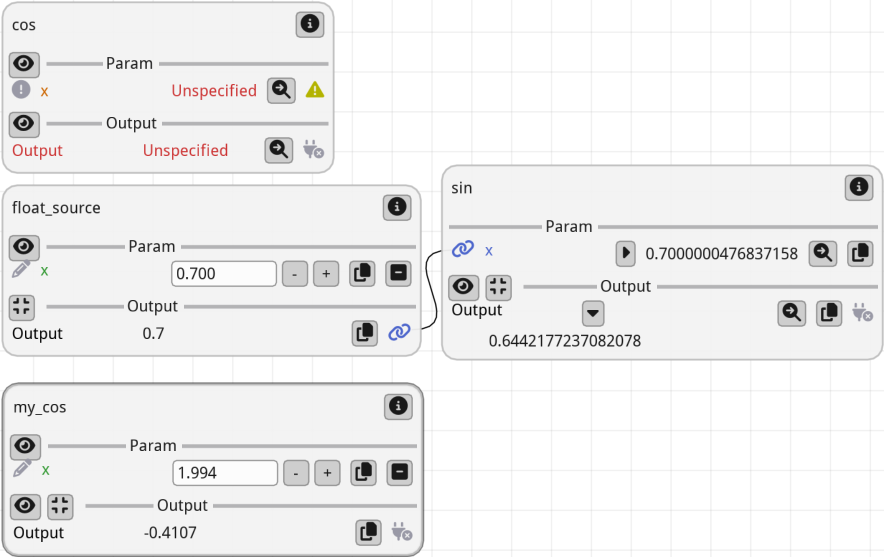

In [6]:
import math
import fiatlight as fl


def float_source(x: float) -> float:
    """A float source, where the user can specify the value of x."""
    return x


def my_cos(x: float) -> float:
    """A wrapper around math.cos that adds types,
    so that Fiatlight can infer the widgets in the GUI."""
    return math.cos(x)


# We create a graph of functions, to which we will add functions manually
graph = fl.FunctionsGraph()

# Add a node that will run math.cos: since this function has no type information,
# Fiatlight **will not** be able to infer the widgets in the GUI)
graph.add_function(math.cos)

# Add a node that will run my_cos: since this function has type information,
# Fiatlight **will** be able to infer the widgets in the GUI
graph.add_function(my_cos)

# Add a function composition that will transfer the output of float_source to math.sin
# (in this case, math.sin will work correctly, since it only has to display the numerical result,
# and does not require an edition widget)
graph.add_function_composition([float_source, math.sin])

# Run the graph
fl.run(graph, app_name="Typed Signatures")

**Visual Output**:
The image above shows the result of running the above code. Notice the differences in GUI behavior for typed vs untyped functions.

**Key Points**:
- Since `cos` is untyped, it is impossible to enter a value for its input parameter.
- The function `sin`, however, works correctly in the graph since it receives an input from `float_source` and does not require an edition widget.


Wrapping Functions
------------------

Creating a wrapper is often extremely simple and necessary when dealing with untyped functions. Wrapping a function allows you to add type information, making it compatible with Fiatlight’s GUI capabilities. Let's see how to wrap the `math.cos` function.

**Why Create a Wrapper?**

The `math.cos` function from Python's standard library does not have type annotations. Without these annotations, Fiatlight cannot automatically create a GUI for it. By creating a wrapper, we add the necessary type information.

**Example: Wrapping `math.cos`**

Below, we create a simple wrapper for `math.cos` that includes type annotations. This allows Fiatlight to generate a GUI for the function.

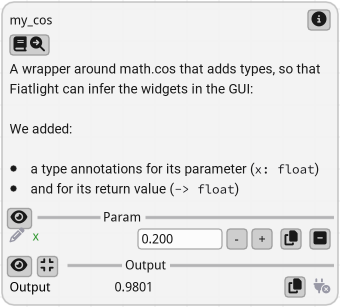

In [6]:
import math
import fiatlight as fl

# Original function without type annotations
def my_cos(x: float) -> float:
  """A wrapper around math.cos that adds types, so that Fiatlight can infer the widgets in the GUI:

  We added:
    * a type annotations for its parameter (`x: float`)
    * and for its return value (`-> float`)
  """
  return math.cos(x)

# Run the wrapped function with Fiatlight
fl.run(my_cos, app_name="Wrapped Cosine Function")

When running the above code, Fiatlight generates a GUI that allows you to input a float value for `x` and see the result of `math.cos(x)`.

_As an additional benefit, the documentation you wrote in the wrapper is visible in the function node!_


Registered Types
================

Introduction
------------

Fiatlight maintains a central registry that links data types (e.g., primitive types or custom data types) with GUI types. This registry allows Fiatlight to automatically create GUIs for functions based on their type annotations.

For more information:

* **Gui Registry**: See the [documentation](manual_registry_source) for detailed information
* **GUI Types**: The GUI Types are all descendant of `AnyDataWithGui`, which is a generic type that can be used to create custom widgets for your data types. See its [API](api_any_data_with_gui).


Using registered types
----------------------

Registered types provide dedicated widgets, enabling automatic GUI creation for function parameters and outputs.

> Tip: use the command `fiatlight types` in a terminal (or console) to list the registered types and their associated widgets. See "[Fiatlight command line utility](manual_cli)" for more information.

Below is an extract of the output of the `fiatlight types` command:

    > fiatlight types
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | Data Type                                          | Gui Type                                                              |
    +====================================================+=======================================================================+
    | int                                                | IntWithGui                                                            |
    |                                                    |   A highly customizable int widget.                                   |
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | float                                              | FloatWithGui                                                          |
    |                                                    |   A highly customizable float widget.                                 |
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | str                                                | StrWithGui                                                            |
    |                                                    |   A Gui for a string with resizable input text, with a popup for      |
    |                                                    | multiline editing.                                                    |
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | bool                                               | BoolWithGui                                                           |
    |                                                    |   A bool widget. Can use a checkbox or a toggle.                      |
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | ColorRgb                                           | ColorRgbWithGui                                                       |
    |   synonym for tuple[int, int, int] describing an   |   A nice color picker for RGB colors (int)                            |
    | RGB color, with values in [0, 255] (NewType)       |                                                                       |
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | ...                                                | ...                                                                   |


Example with Matplotlib Figures
-------------------------------

Let's look at an example using `TextPath` and `matplotlib.figure.Figure`, which are registered types in Fiatlight:

- `fl.fiat_types.TextPath` is an alias for str, but it is registered to be displayed with a file selection dialog.
- `matplotlib.figure.Figure` is registered to be displayed as a plot in the GUI

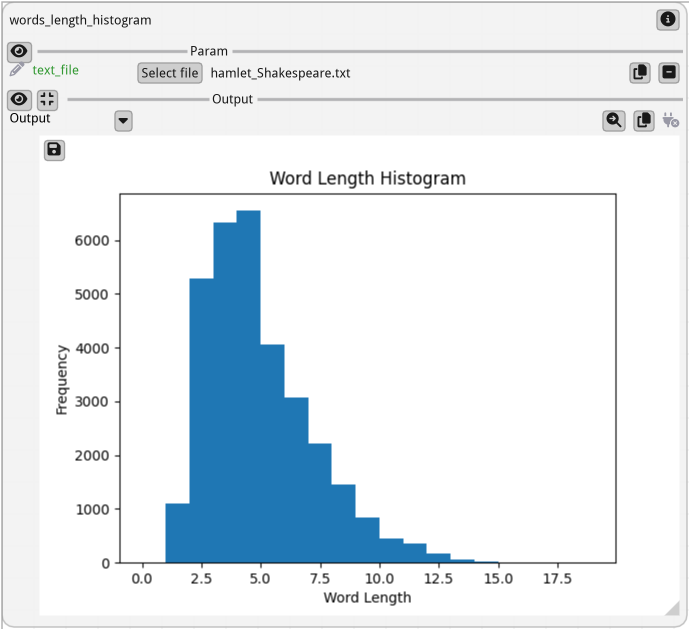

In [7]:
import fiatlight as fl
import matplotlib.figure
import matplotlib.pyplot as plt

def words_length_histogram(text_file: fl.fiat_types.TextPath) -> matplotlib.figure.Figure:
    "Create a histogram of the lengths of words in a text file."
    with open(text_file) as f:
        text = f.read()
    words = text.split()
    lengths = [len(word) for word in words]
    fig, ax = plt.subplots()
    ax.hist(lengths, bins=range(0, 20))
    ax.set_title("Word Length Histogram")
    ax.set_xlabel("Word Length")
    ax.set_ylabel("Frequency")
    return fig


fl.run(words_length_histogram, app_name="Registered types")

Controlling Function Execution
==============================

By default, the function will be called only when one of its inputs has changed (either because the user
entered a new value, or because an input is connected to another function that has changed).

You can control the behavior of the function by setting attributes on the function object.

* `invoke_async` (default=False): if set to True, the function will be called asynchronously
* `invoke_manually` (default=False): if set to True, the function will be called only if the user clicks on the "invoke" button
* `invoke_always_dirty` (default=False): if set to True, the function output will always be considered out of date. Depending on the value of `invoke_manually`:
  - if "invoke_manually" is True, the "Refresh needed" label will be displayed
  - if "invoke_manually" is False, the function will be called at each frame

> _Note: a "live" function is thus a function with `invoke_manually=False` and `invoke_always_dirty=True`_


Configuring "Live" functions
----------------------------

**Example: a live function that display a camera image**

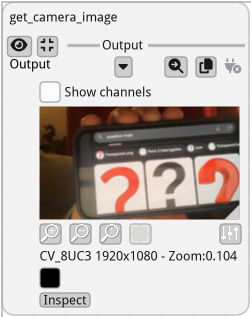

In [20]:
import fiatlight as fl
from fiatlight.fiat_kits.fiat_image import ImageU8_3
import cv2  # we use OpenCV to capture the camera image (pip install opencv-python)
cap = cv2.VideoCapture(0)  # you will need a camera!

def get_camera_image() -> ImageU8_3 | None:
    ret, frame = cap.read()
    return ImageU8_3(frame) if ret else None

# Set flags to make this a live function (called automatically at each frame)
fl.add_fiat_attributes(get_camera_image, invoke_always_dirty=True)

fl.run(get_camera_image, app_name="Live camera image")

Using Async Functions
---------------------

**Example: an async function**

When your function is slow, you can set the `invoke_async` flag to True. In the example below, the yellow spinner indicates that the function is running, while keeping the GUI responsive.

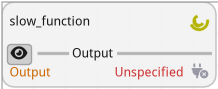

In [5]:
import fiatlight as fl
import time
def slow_function() -> int:
    time.sleep(5)
    return 42

fl.add_fiat_attributes(slow_function, invoke_async=True)
fl.run(slow_function, app_name="Async function")

# Note:
# You can also use the `@fl.with_fiat_attributes` decorator to set the flags directly on the function:
# @fl.with_fiat_attributes(invoke_async=True)
# def slow_function() -> int:
#    ...

"Stoppable" async Functions
---------------------
In the case of async function, you may also set:
* `invoke_async_stoppable`(default=False): if true a GUI button will be displayed to stop the async function while it is running.

In this case, you will need to check the flag `invoke_async_shall_stop` in your function to know if the function should stop.

**Example:**

In [6]:
def my_async_function():
    # ...  # some initialization
    while True:  # inner loop of the function processing (can be any form of loop)
        # ...  # some processing
        if hasattr(my_async_function, "invoke_async_shall_stop") and my_async_function.invoke_async_shall_stop:
            my_async_function.invoke_async_shall_stop = False  # reset the flag
            break
        # ... # continue the function processing

Manual Invocation Example
-------------------------

**Example: a function that needs to be called manually**

If you set the `invoke_manually` flag to True, the function will be called only when the user clicks the "invoke" button (indicated by a "recycle" icon). If the inputs have changed, a "Refresh needed" label will be displayed.

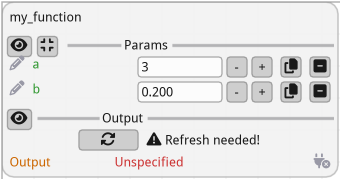

In [7]:
import fiatlight as fl
def my_function(a: int, b: float) -> float:
    return a + b

fl.add_fiat_attributes(my_function, invoke_manually=True)
fl.run(my_function, app_name="Manual invocation")

Handwriting the GUI
===================

Using Edit and Present Callbacks
--------------------------------

You can also customize the GUI for a parameter or output by setting custom callbacks function, namely the "edit" and "present" callbacks.

In this case, you will first wrap the function in a `FunctionWithGui` object, and then set the callbacks for the parameter or output.

In [8]:
import fiatlight as fl

def my_function(a: int) -> float:
    return a * 4

my_function_gui = fl.FunctionWithGui(my_function)

# A callback to edit the parameter. Receive the current value, and return a tuple (bool, new_value)
# my_function_gui.input("a").callbacks.edit = ...

# A callback to present the output. Receive the current value, and return None
# my_function_gui.output().callbacks.present = ...

For more information, see:

* **AnyDataWithGui**: See the [API](api_any_data_with_gui.ipynb) for detailed information.
* **AnyDataWithGuiCallbacks**: See the [API](api_any_data_gui_callbacks.ipynb) for detailed information.


Example: Custom Callbacks
-------------------------

In this example, we define custom edit and present callbacks for the function fahrenheit_to_celsius. The resulting GUI allows the user to input a temperature in Fahrenheit using a custom slider and see the converted temperature in Celsius with a color-coded note indicating whether it is cold, warm, or hot.

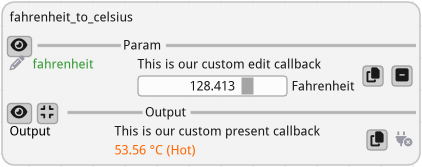

In [9]:
import fiatlight as fl
from imgui_bundle import imgui, hello_imgui, ImVec4


def fahrenheit_to_celsius(fahrenheit: float = 0) -> float:
    return (fahrenheit - 32) * 5 / 9

# This will be our edit callback: it accepts a float and returns a tuple (bool, float)
# where the first element is True if the value has changed, and the second element is the new value
def edit_temperature(fahrenheit: float) -> tuple[bool, float]:
    imgui.text("This is our custom edit callback")
    # Set the width of the slider field to 10 em units (using em units is a good practice to make the GUI dpi aware)
    imgui.set_next_item_width(hello_imgui.em_size(10))
    changed, new_value = imgui.slider_float("Fahrenheit", fahrenheit, -100, 200)
    return changed, new_value

# This will be our present callback: it accepts a float and returns None
def present_temperature(celsius: float) -> None:
    imgui.text("This is our custom present callback")
    note = "Cold" if celsius < 20 else "Hot" if celsius > 40 else "Warm"
    color = ImVec4(0, 0.4, 1, 1) if celsius < 20 else ImVec4(1, 0.4, 0, 1) if celsius > 40 else ImVec4(0, 1, 0, 1)
    imgui.text_colored(color, f"{celsius:.2f} °C ({note})")


fahrenheit_to_celsius_gui = fl.FunctionWithGui(fahrenheit_to_celsius)
fahrenheit_to_celsius_gui.output().callbacks.present = present_temperature
fahrenheit_to_celsius_gui.input("fahrenheit").callbacks.edit = edit_temperature

fl.run(fahrenheit_to_celsius_gui, app_name="Custom callbacks")

Gui Nodes
---------

Gui Nodes are specialized nodes in Fiatlight, dedicated to functions which do not return values but instead displaying a user interface using ImGui widgets. Gui Nodes are called at every frame, ensuring that the GUI is always responsive and up-to-date.

Gui Nodes are particularly useful for:
* Displaying interactive visualizations (plots, etc)
* Creating dashboards
* Providing user controls (e.g., sliders, buttons) that alter global variables

> Notes:
> * Gui Nodes are not meant to return values
> * Your GUI function should be fast. If you need to perform heavy computations, consider using AnyDataWithGui, where the "on_change" callback can be used to cache heavy computations.

### Example: Visualizing a Heart Curve with a GUI Node

In this example, we demonstrate how to create a GUI node that visualizes a heart curve. The size of the heart dynamically changes over time to simulate a heartbeat.

**Explanation**:
1. time_seconds: This function returns the current time in seconds and is set to always be re-evaluated at every frame.
2. heart_curve: Generates the x and y coordinates of a heart curve that changes size over time to simulate a heartbeat.
3. gui_curve: A GUI node that visualizes the heart curve using ImPlot. It updates the curve at every frame to reflect the beating heart.
4. gui_curve is a gui function. So, we wrap it in a GuiNode to display the heart curve with either
   `GuiNode(gui_curve)` or `graph.add_gui_node(gui_curve)`.

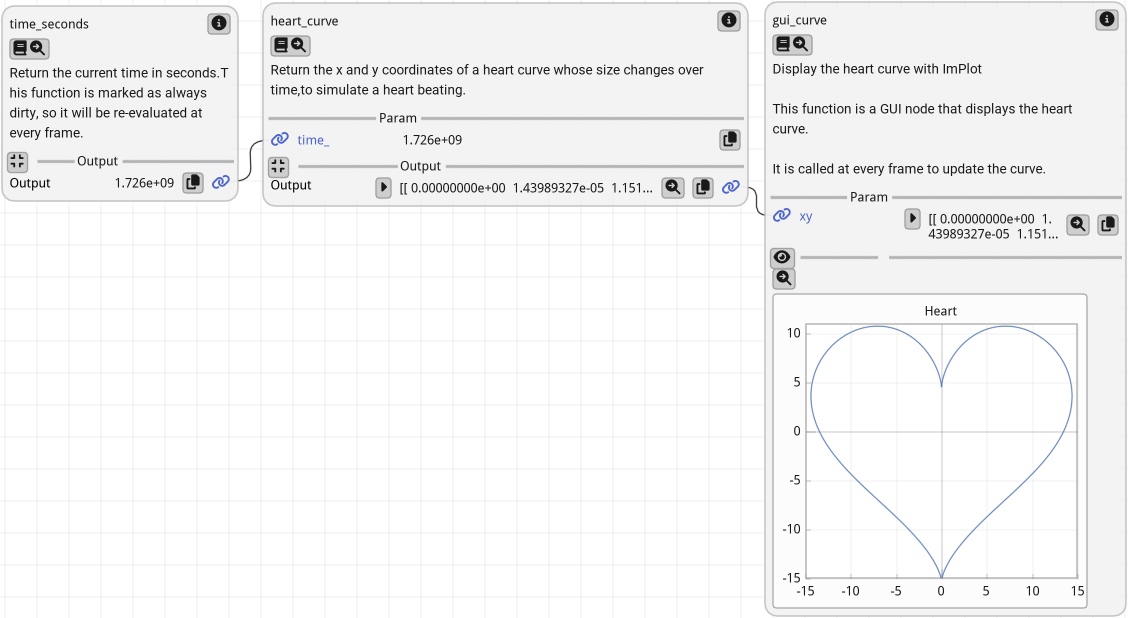

In [10]:
import fiatlight as fl
from imgui_bundle import hello_imgui, implot
import numpy as np
from numpy.typing import ArrayLike
import time

@fl.with_fiat_attributes(invoke_always_dirty=True)
def time_seconds() -> float:
    """Return the current time in seconds.
    This function is marked as always dirty, so it will be re-evaluated at every frame.
    """
    return time.time()

def heart_curve(time_: float) -> ArrayLike:
    """Return the x and y coordinates of a heart curve whose size changes over time,
    to simulate a heart beating.
    """
    vals = np.arange(0, np.pi * 2, 0.01)
    x0 = np.power(np.sin(vals), 3) * 16
    y0 = 13 * np.cos(vals) - 5 * np.cos(2 * vals) - 2 * np.cos(3 * vals) - np.cos(4 * vals)

    # Heart pulse rate and time tracking
    heart_pulse_rate = 80
    phase = time_ * heart_pulse_rate / (np.pi * 2)
    k = 0.8 + 0.1 * np.cos(phase)
    return np.array([x0 * k, y0 * k])

def gui_curve(xy: ArrayLike) -> None:
    """Display the heart curve with ImPlot

    This function is a GUI node that displays the heart curve.

    It is called at every frame to update the curve.
    """
    if implot.begin_plot("Heart", hello_imgui.em_to_vec2(21, 21)):
        implot.setup_axes_limits(-15, 15, -15, 11)
        implot.plot_line("", xy[0], xy[1])
        implot.end_plot()

# Run the graph
# Method 1: Using the run function, and wrapping the gui_curve function in a GuiNode
fl.run([time_seconds, heart_curve, fl.GuiNode(gui_curve)], app_name="HeartCurve")

# Method 2: Using a FunctionsGraph
# graph = fl.FunctionsGraph()
# graph.add_function(time_seconds)
# graph.add_function(heart_curve)
# graph.add_gui_node(gui_curve)  # Add the gui_curve function as a GuiNode
# graph.add_link(time_seconds, heart_curve)
# graph.add_link(heart_curve, gui_curve)
# fl.run(graph, app_name="HeartCurve")

### Example: a GUI node with serializable state

When adding a GuiNode, you can pass a serializable data class to store the options of the GUI function. This allows you to save the state of the GUI function and reload it when restarting the application.

In the example below, we demonstrate how to create a GUI node that multiplies an input value by a factor. The factor can be adjusted by the user and is stored in a serializable data class. The factor value is reloaded upon restarting the application.

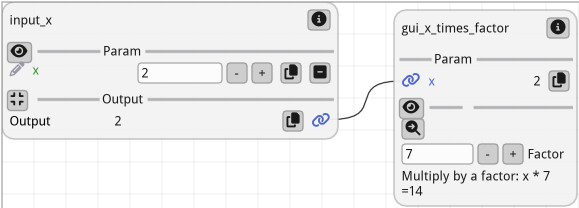

In [11]:
import fiatlight as fl
from imgui_bundle import imgui
from pydantic import BaseModel

def input_x(x: int) -> int:
    """a function that will be displayed in the function graph, in order to let the user input a value."""
    return x

class WhatToMultiply(BaseModel):
    """A serializable data class that will be used to store the options of the GUI function `gui_x_times_factor"""
    factor: int = 3

WHAT_TO_MULTIPLY = WhatToMultiply()

def gui_x_times_factor(x: int) -> None:
    """A GUI function that multiplies the input by a serializable factor.
    It will be added via graph.add_gui_node(gui_x_times_factor, gui_serializable_data=WHAT_TO_MULTIPLY).
    It uses a serializable data class to store its options, which will be reloaded upon restarting the application.
    """
    _, WHAT_TO_MULTIPLY.factor = imgui.input_int("Factor", WHAT_TO_MULTIPLY.factor)
    imgui.text(f"Multiply by a factor: x * {WHAT_TO_MULTIPLY.factor} ={x * WHAT_TO_MULTIPLY.factor}")

# Run the graph
fl.run([input_x, fl.GuiNode(gui_x_times_factor, gui_serializable_data=WHAT_TO_MULTIPLY)], app_name="GuiNode with serializable state")

Debugging Functions exceptions
==============================

When a function raises an exception, Fiatlight catches and displays it without crashing the application. Instead, you will see a "Debug this exception" button that you can use to trigger the exception again.

This feature is invaluable for debugging and making your functions more robust. If you are using a debugger, you will be taken directly to the point where the exception occurred, with the correct inputs to reproduce the bug.

> _Note: this feature can be disabled with:
>     `fl.get_fiat_config().run_config.catch_function_exceptions = False`


Example: a Math Exception
-------------------------

With this setup, if the input value of a causes math.log(cos_a) to produce an error (when cos_a is negative).

Fiatlight will catch and display the exception, allowing you to debug it easily.

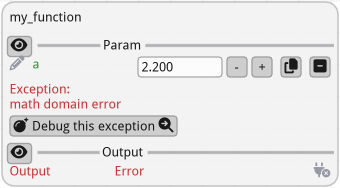

In [12]:
import fiatlight as fl
import math

def my_function(a: float) -> float:
    cos_a = math.cos(a)
    r = math.log(cos_a)
    return r

fl.run(my_function, app_name="Math domain exception")

Fiat Tuning: Tune functions
===========================

Introduction
------------

Fiatlight provides you with powerful tools to visually debug the intermediate states of your function.

By adding a fiat_tuning attribute to a function, you can provide additional information that will be displayed in the GUI node for this function. This attribute is a dictionary and can contain named data values or descendants of AnyDataWithGui. This information can be used to fine-tune the function, debug it, or visualize intermediate states.

Moreover, this information can be updated in the GUI, even if the function is a long-running process called asynchronously.

> _Example: The image below shows a sort competition between different algorithms. The GUI nodes display in real time the evolving state of each algorithm, using "fiat_tuning" (see tutorial "demos/tutorials/sort_competition" for more details)._
>
> <img src="_static/images/sort_competition.jpg" width="30%">


Example: Measure Execution Time
-------------------------------

In the example below, we will add a simple float into the fiat_tuning attribute of the sort_list function. This float will represent the duration of the sort operation.

The collapsible region "Fiat Tuning" will display this duration:we can see that in this example, it takes about 0.75 seconds to sort a list of 10,000,000 elements.

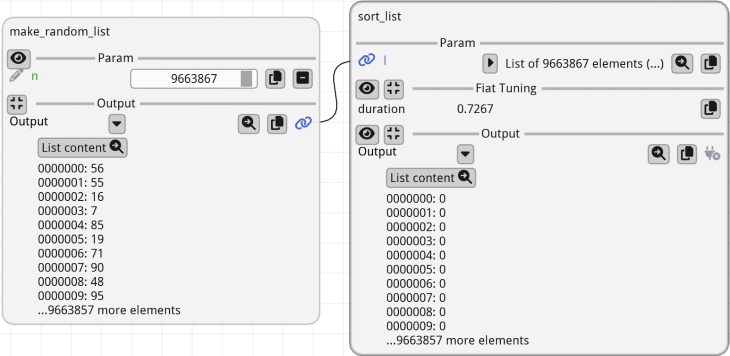

In [13]:
import fiatlight as fl
import time

@fl.with_fiat_attributes(n__range=(1, 10_000_000))
def make_random_list(n: int) -> list[int]:
    import random
    return [random.randint(0, 100) for _ in range(n)]


def sort_list(l: list[int]) -> list[int]:
    start = time.time()
    r = sorted(l)
    duration = time.time() - start
    fl.add_fiat_attributes(sort_list, fiat_tuning={"duration": duration})
    return r

fl.run([make_random_list, sort_list], app_name="Sort duration")

Example: Tune using an Image
----------------------------

The fiat_tuning attribute can also be used to display widgets (which must be descendants of AnyDataWithGui) in the GUI node.

In the example below, we will add an image widget (ImageWithGui) into the fiat_tuning attribute.

> _[demos/images/toon_edges.py](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/demos/images/toon_edges.py) is a good example of how to use the `fiat_tuning` attribute._
>
> _`add_toon_edges` is a complex function that adds a toon effect to an image, by adding colored edges to the image contours._
> _The contour detection is extremely sensitive to the parameters, and the `fiat_tuning` attribute is used to display the intermediate states of the function in the GUI._

Here are some commented extracts of the function:

In [14]:
from fiatlight.fiat_kits.fiat_image import ImageU8_3, ImageU8_1

def add_toon_edges(
image: ImageU8_3,
# ... lots of parameters ...
) -> ImageU8_3:
    edges: ImageU8_1 # = ...             (compute the edges)
    dilated_edges: ImageU8_1 #  = ...    (dilate the edges)
    image_with_edges: ImageU8_3  # = ... (superimpose the edges on the image)

    # fiat_tuning: add debug internals to ease fine-tuning the function inside the node
    from fiatlight.fiat_kits.fiat_image import ImageWithGui

    # Add to fiat_tuning any variable you want to be able to fine-tune or debug in the function node
    #     * Either a raw type (int, float, str, etc.): see durations
    #     * Or a descendant of AnyDataWithGui: see "canny", "dilate", "image_with_edges"
    fl.add_fiat_attributes(add_toon_edges, fiat_tuning={
        "duration_canny": duration_canny,
        "duration_dilate": duration_dilate,
        "duration_blur": duration_blur,
        "duration_merge": duration_merge,
        "canny": ImageWithGui(edges),
        "dilate": ImageWithGui(dilated_edges),
        "image_with_edges": ImageWithGui(image_with_edges),
    })

    # return the image with edges
    return image_with_edges

Once these internals are set, you can see the function "Internals" in the GUI:

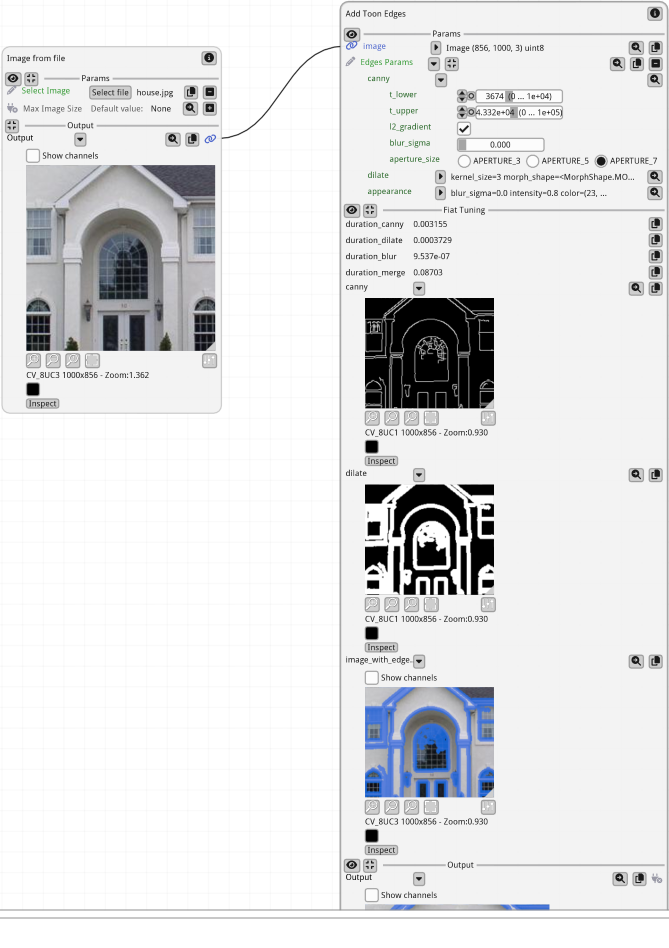

In [15]:
import fiatlight as fl
from fiatlight.fiat_kits.fiat_image import ImageU8_GRAY, ImageU8_3, image_source
from fiatlight.demos.images.toon_edges import add_toon_edges

fl.run([image_source, add_toon_edges], app_name="Toon edges")

> _The image above shows the GUI node for the toon_edges function, with the expanded "Fiat Tuning" section:_
> _it displays the execution time of each step, as well as an image representation of the intermediate edges and dilated edges._


Sub-class FunctionWithGui
=========================

Introduction
------------

By subclassing `FunctionWithGui`, you can fully customize the behavior of the function:
- you can add a GUI for the internal state of the function (e.g. displaying a live plot of a sound signal)
- you can add a heartbeat function that will be called at each frame (e.g. get the latest data from a sensor)
- you can save and load the internal GUI presentation options to/from a JSON file (e.g. to save the layout of a plot)

Example: Camera & Internal State
--------------------------------

[fiatlight.fiat_kits.fiat_image.CameraImageProviderGui](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiat_kits/fiat_image/camera_image_provider.py)
is a good example of a custom FunctionWithGui class.

You can see it in action below:

2024-09-14 15:42:54.462 Python[44008:11709418] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


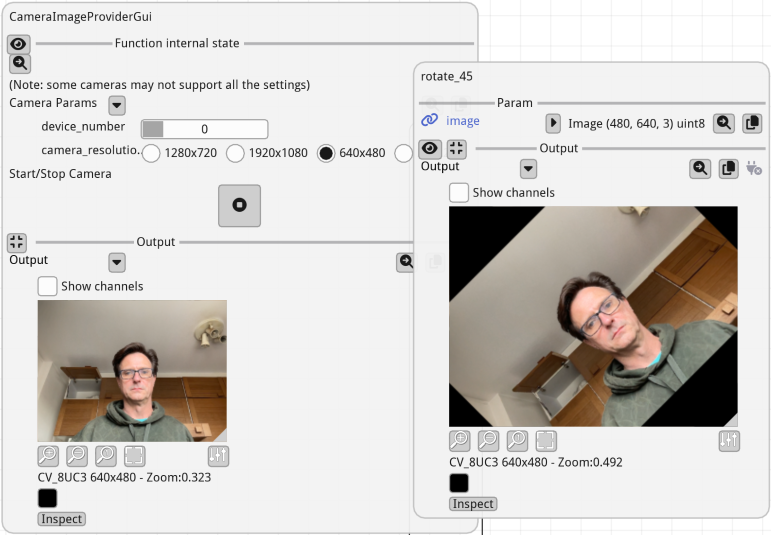

In [16]:
import fiatlight as fl
from fiatlight.fiat_kits.fiat_image import CameraImageProviderGui, ImageU8_3
import cv2

def rotate_45(image: ImageU8_3) -> ImageU8_3:
    transform = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), 45, 1)
    return cv2.warpAffine(image, transform, (image.shape[1], image.shape[0]))  # type: ignore

camera_provider_gui = CameraImageProviderGui()
fl.run([camera_provider_gui, rotate_45], app_name="Camera provider with rotation")

**Commented extracts of [camera_image_provider.py](../fiat_kits/fiat_image/camera_image_provider.py)**

Look at the `CameraImageProviderGui` class that extends `FunctionWithGui`:

> Notes:
> * `CameraImageProviderGui` der uses a `CameraImageProvider` class that provides images from a camera.
> * `CameraParams` contains the state of the camera (device number, brightness, contrast, etc.).
    >    This state is serialized. As it is as a Pydantic model, a GUI for it is automatically created by Fiatlight,
    >    and its state is serialized.

**CameraImageProviderGui (a descendant of FunctionWithGui)**:

In [18]:
from fiatlight.fiat_notebook import look_at_code
%look_at_python_code
fiatlight.fiat_kits.fiat_image.camera_image_provider.CameraImageProviderGui

class CameraImageProviderGui(FunctionWithGui):
    """A Gui for the camera image provider"""

    _camera_provider: CameraImageProvider
    _camera_params_gui: AnyDataWithGui[CameraParams]

    def __init__(self) -> None:
        super().__init__(self.f, "CameraImageProviderGui")

        from fiatlight.fiat_togui import to_data_with_gui

        self._camera_provider = CameraImageProvider()
        self._camera_params_gui = to_data_with_gui(self._camera_provider.camera_params)
        self._camera_params_gui.label = "Camera Params"

        self.internal_state_gui = self._internal_state_gui
        self.save_internal_gui_options_to_json = self._save_internal_gui_options_to_json
        self.load_internal_gui_options_from_json = self._load_internal_gui_options_from_json

        # A flag for fiatlight to set this as a live function
        self.invoke_always_dirty = True

    def f(self) -> ImageU8_3 | None:
        return self._camera_provider.get_image()

    def _save_internal_gui_options_to_json(self) -> JsonDict:
        r = self._camera_provider.camera_params.model_dump(mode="json")
        return r

    def _load_internal_gui_options_from_json(self, json_dict: JsonDict) -> None:
        camera_params = CameraParams.model_validate(json_dict)
        self._camera_provider.camera_params = camera_params
        self._camera_params_gui.value = camera_params

    def _show_cam_button(self) -> None:
        started = self._camera_provider.started()
        with imgui_ctx.begin_horizontal("CamButton"):
            imgui.spring()
            button_size = hello_imgui.em_to_vec2(3, 3)
            if not started:
                if imgui.button(icons_fontawesome_6.ICON_FA_CIRCLE_PLAY, button_size):
                    self._camera_provider.start()
            else:
                if imgui.button(icons_fontawesome_6.ICON_FA_CIRCLE_STOP, button_size):
                    self._camera_provider.stop()
            imgui.spring()

    def _internal_state_gui(self) -> bool:
        with fontawesome_6_ctx():
            with imgui_ctx.begin_vertical("CamParams"):
                imgui.text_wrapped("(Note: some cameras may not support all the settings)")
                changed = self._camera_params_gui.gui_edit()
                if changed:
                    assert isinstance(self._camera_params_gui.value, CameraParams)
                    self._camera_provider.apply_params(self._camera_params_gui.value)
                imgui.text("Start/Stop Camera")
                self._show_cam_button()

        return False

**CameraParams (serialized internal state)**:

In [19]:
import fiatlight as fl
from enum import Enum
from pydantic import BaseModel
import cv2

class CameraResolution(Enum):
    HD_1280_720 = [1280, 720]
    FULL_HD_1920_1080 = [1920, 1080]
    VGA_640_480 = [640, 480]

@fl.base_model_with_gui_registration(device_number__range= (0, 5), brightness__range= (0, 1), contrast__range= (0, 1))
class CameraParams(BaseModel):
    device_number: int = 0
    brightness: float = 0.5
    contrast: float = 0.5
    camera_resolution: CameraResolution = CameraResolution.VGA_640_480


class CameraImageProvider:
    '''A class that provides images from a camera'''
    camera_params: CameraParams
    cv_cap: cv2.VideoCapture | None = None
    ...